<a href="https://colab.research.google.com/github/zkatemor/thesaurus/blob/word2vec_keras_sample/bayes_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация по размеченным данным из RuSentiLex с помощью Наивного Байеса и KNN

In [209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc,roc_curve,classification_report
import seaborn as sns
from sklearn.pipeline import Pipeline
import re
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [0]:
df = pd.read_csv('drive/My Drive/coursework/rusentilex.csv')

In [212]:
df.head(3)

,term,tone
0,остепеняться,positive
1,трудолюбивый,positive
2,беспалевный,positive


In [0]:
list_category = df['tone'].unique().tolist()

Перемешивание данных

In [0]:
df = sklearn.utils.shuffle(df)

In [231]:
df.head(3)

,term,tone
691,чародейка,positive
2730,встряхиваться,positive
2579,потеплеть,positive


Визуализация данных

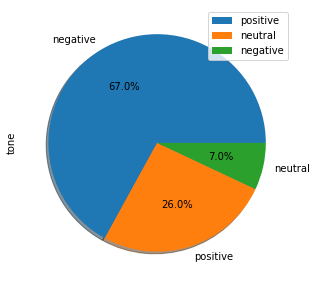

In [215]:
df['tone'].value_counts().plot(kind = 'pie',figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
plt.legend(list_category)
plt.show()

Разделение на тестовую и обучающую

In [0]:
train, test = train_test_split(df,random_state = 0,stratify = df['tone'],test_size = 0.3)

In [217]:
print("Train data shape = {} ".format(train.shape))
print("Test data shape = {}".format(test.shape))

Train data shape = (7467, 2) 
Test data shape = (3201, 2)


                  term      tone
10327    краснобайство  negative
5044        монополист  negative
5305   попустительство  negative
976           ободрить  positive
8726         оборванец  negative


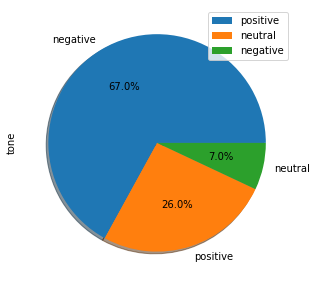

In [218]:
train["tone"].value_counts().plot(kind = 'pie',figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
plt.legend(list_category)
print(train.head())
plt.show()

                   term      tone
1735   первостатейность  positive
4452            сексизм  negative
3644           обкурить  negative
10126        кровопийца  negative
394    беспроигрышность  positive


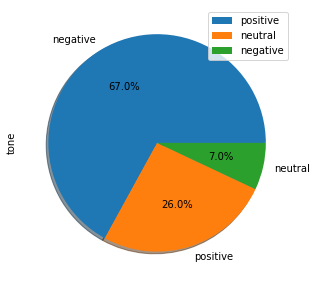

In [219]:
test["tone"].value_counts().plot(kind = 'pie',figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
print(test.head())
plt.legend(list_category)
plt.show()

Небольшая предобработка

In [0]:
def preprocess(sms):
  pattern = re.compile('[^[А-Яa-яЁё\s]')
  sms = re.sub(pattern,' ',sms)
  sms = re.sub('\s+',' ',sms)
  sms = sms.lower()
  return sms

Из слова в вектор с помощью TF-IDF

In [0]:
encoder = LabelEncoder()
vectorizer  = TfidfVectorizer()

train_x = vectorizer.fit_transform(train['term'])
train_y = encoder.fit_transform(train['tone'])

Обучение с помощью наивной бейесовской фильтрации

In [242]:
param_grid = dict({"alpha":[1,10,50,100,150,200],
                   'fit_prior' :[True,False]})
grid = GridSearchCV(MultinomialNB(), param_grid, cv=10)
grid.fit(train_x, train_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1, 10, 50, 100, 150, 200],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
from sklearn.metrics import f1_score

In [0]:
def scoring_data(grid, data):
  x = vectorizer.transform(data['term'])
  y = encoder.transform(data['tone'])
  score = grid.score(x, y)
  print("Accuracy of Model is {}".format(score))
  y_pred = grid.predict(x)
  confution_matrix = pd.crosstab(y_pred, y, rownames = ['actual'], colnames = ['prediction'])
  print(classification_report(y, y_pred=y_pred))
  sns.heatmap(confution_matrix, annot=True, cmap = 'Greens', xticklabels=list_category, yticklabels=list_category)

Обучилось с точностью 67 процентов, матрицу ошибок нужно поправить

Accuracy of Model is 0.6701030927835051
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2145
           1       0.00      0.00      0.00       224
           2       0.33      0.00      0.00       832

    accuracy                           0.67      3201
   macro avg       0.33      0.33      0.27      3201
weighted avg       0.54      0.67      0.54      3201



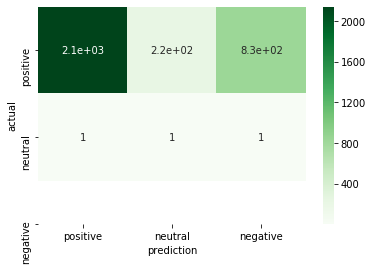

In [244]:
scoring_data(grid,test)

Обучение с помощью k-ближайших соседей

In [237]:
knn_param_grid =dict({'n_neighbors':[3,6,8,10]})
knn_grid = GridSearchCV(KNeighborsClassifier(),cv = 5, param_grid=knn_param_grid) 
knn_grid.fit(train_x,train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': [3, 6, 8, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'n_neighbors': 6}


Text(0.5, 1.0, '10 fold Cross validation result')

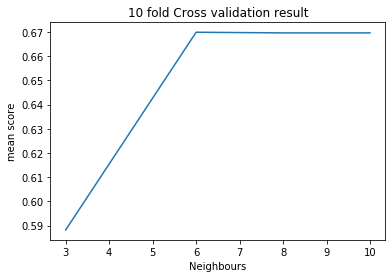

In [238]:
print(knn_grid.best_params_)
score = knn_grid.cv_results_
neighbours = knn_param_grid['n_neighbors']
mean_score = score['mean_test_score']
plt.plot(neighbours,mean_score)
plt.xlabel('Neighbours')
plt.ylabel('mean score')
plt.title("10 fold Cross validation result")

Accuracy of Model is 0.6701030927835051
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2145
           1       0.00      0.00      0.00       224
           2       0.00      0.00      0.00       832

    accuracy                           0.67      3201
   macro avg       0.22      0.33      0.27      3201
weighted avg       0.45      0.67      0.54      3201



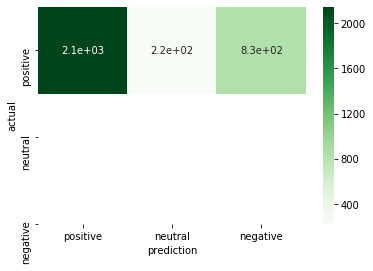

In [236]:
scoring_data(knn_grid, test)

Мини-проверка

In [229]:
text = 'замечательный'
text = preprocess(text)
text = vectorizer.transform([text])
category = grid.predict(text)
print(encoder.inverse_transform(category))

['positive']


In [230]:
text = 'ужасный'
text = preprocess(text)
text = vectorizer.transform([text])
category = grid.predict(text)
print(encoder.inverse_transform(category))

['negative']


Попытка классифицировать нужные данные

In [0]:
import json

In [0]:
# загружаем неразмеченный словарь из json файла
with open('drive/My Drive/coursework/unallocated_dictionary.json', 'r', encoding='utf-8') as f:
    js = json.load(f)

In [0]:
unallocated_words = [[word[0][:-5]] for word in js]

In [267]:
unallocated_words[:5]

[['телефон'], ['очень'], ['экран'], ['хороший'], ['камера']]

In [0]:
def predict_tone(text):
  text = preprocess(text)
  text = vectorizer.transform([text])
  category = grid.predict(text)
  return encoder.inverse_transform(category)

In [0]:
answers = [predict_tone(word[0]) for word in unallocated_words]

In [0]:
answers = [answers[i][0] for i in range(0, len(answers))]

In [306]:
answers[:5]

['negative', 'negative', 'negative', 'positive', 'negative']

Просмотрела позитивные слова

In [292]:
for i in range(0, 200):
  if answers[i] == 'positive':
    print(unallocated_words[i])

['хороший']
['удобный']
['самый']
['довольный']
['нормальный']
['качественный']
['достоинство']
['нравиться']
['супер']
['мощный']
['понравиться']
['приятный']
['отзыв']
['пожалеть']
['шустрый']


Просмотрела негативные слова

In [294]:
for i in range(0, 20):
  if answers[i] == 'negative':
    print(unallocated_words[i])

['телефон']
['очень']
['экран']
['камера']
['весь']
['работать']
['день']
['батарея']
['приложение']
['качество']
['отличный']
['год']
['цена']
['один']
['аппарат']
['звук']
['купить']
['который']


Нейтральных слов не обнаружено, из-за этого ошибка на матрице

In [0]:
for i in range(0, len(answers)):
  if answers[i] == 'neutral':
    print(unallocated_words[i])

In [0]:
keys = [word[0] for word in js]
dictionary = dict(zip(keys, answers))

In [285]:
import itertools
dict(itertools.islice(dictionary.items(), 15))

{'батарея_NOUN': 'negative',
 'весь_ADJF': 'negative',
 'год_NOUN': 'negative',
 'день_NOUN': 'negative',
 'камера_NOUN': 'negative',
 'качество_NOUN': 'negative',
 'один_ADJF': 'negative',
 'отличный_ADJF': 'negative',
 'очень_ADVB': 'negative',
 'приложение_NOUN': 'negative',
 'работать_INFN': 'negative',
 'телефон_NOUN': 'negative',
 'хороший_ADJF': 'positive',
 'цена_NOUN': 'negative',
 'экран_NOUN': 'negative'}

Сохранение словаря в csv файл

In [0]:
# сохраняем словарь в csv файл
import csv
from itertools import zip_longest
d = [keys, answers]
export_data = zip_longest(*d, fillvalue = '')
with open('drive/My Drive/coursework/tagged_dictionary_bayes.csv', 'w', encoding='utf-8', newline='') as f:
      wr = csv.writer(f)
      wr.writerow(("term", "tone"))
      wr.writerows(export_data)
f.close()